<h1> 5. Interactive Data Analysis </h1>

This notebook introduces carrying out interactive data analysis of data in BigQuery using Cloud Datalab.

This cell, for example, is a mark-down cell.  Which is why you are seeing text. The cell that follows is a Python code cell. The output of that cell is whatever is printed out from it.

In [1]:
a = 3
b = a + 5
print "a={} b={}".format(a,b)

a=3 b=8


Because the markdown comments are HTML, it can even include Javascript, for example to create a table of contents, as shown below:

<div id="toc"></div>

In [3]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h2> Relative path </h2>

I created this notebook in 05_bqdatalab folder of the git repo for the book. So, you might see a path that ends in that. But the path will start with /content which is mapped to a local folder on the computer that is running Datalab.

In [ ]:
!pwd

<h2> What's installed? </h2>

In [ ]:
!pip freeze

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

<h2> Installing dependencies </h2>

Regular Python dependencies can be installed using pip

In [ ]:
!pip install google-cloud

In [ ]:
%bash
apt-get update
apt-get -y install python-mpltoolkits.basemap

<h2> Juypter magic </h2>

In [12]:
%html
This cell will print out a <b> HTML </b> string.

In [13]:
%bigquery schema --table flights.tzcorr

<h2> Calls to BigQuery </h2>

Let's draw a PDF of different arrival delays

In [17]:
import google.datalab.bigquery as bq
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE DEP_DELAY >= 10 AND RAND() < 0.01
"""
df = bq.Query(sql).execute().result().to_dataframe()

In [18]:
df.describe()

,ARR_DELAY,DEP_DELAY
count,13717.000000,13780.000000
mean,46.137494,51.000363
std,62.389715,59.757945
min,-42.000000,10.000000
25%,11.000000,17.000000
50%,27.000000,30.000000
75%,59.000000,61.000000
max,1079.000000,1098.000000


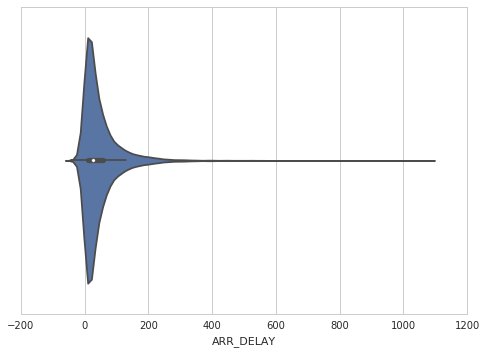

In [19]:
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', inner='box', orient='h')
#ax.axes.set_xlim(0, 30)

In [20]:
import google.datalab.bigquery as bq
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE RAND() < 0.001
"""
df = bq.Query(sql).execute().result().to_dataframe()

In [21]:
df.describe()

,ARR_DELAY,DEP_DELAY
count,6189.000000,6214.000000
mean,4.223784,9.376569
std,37.655686,35.206738
min,-58.000000,-23.000000
25%,-14.000000,-5.000000
50%,-5.000000,-1.000000
75%,8.000000,8.000000
max,740.000000,761.000000


In [23]:
df['ontime'] = df['DEP_DELAY'] < 10
df[df['ARR_DELAY'] > 0].head()

,ARR_DELAY,DEP_DELAY,ontime
102,2.0,0.0,True
103,2.0,0.0,True
104,2.0,0.0,True
105,2.0,0.0,True
120,3.0,0.0,True


(-50, 200)

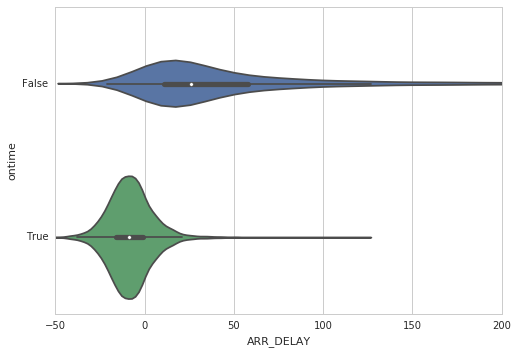

In [24]:
import seaborn as sns
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h')
ax.set_xlim(-50, 200)

(-50, 50)

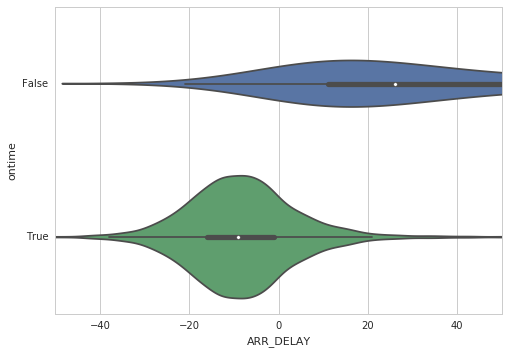

In [25]:
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', 
                    inner='box', orient='h', gridsize=1000)
ax.set_xlim(-50, 50)

In [29]:
import google.datalab.bigquery as bq
depdelayquery = """
SELECT
  *
FROM (
  SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    STDDEV(ARR_DELAY) AS stddev_arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr`
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY
"""

In [30]:
depdelay = bq.Query(depdelayquery).execute().result().to_dataframe()
depdelay[:5]

,DEP_DELAY,arrival_delay,stddev_arrival_delay,numflights
0,-23.0,-24.005747,11.095207,522
1,-22.0,-23.258693,12.300774,719
2,-21.0,-22.606495,12.094192,1047
3,-20.0,-21.538365,12.075209,1590
4,-19.0,-20.591874,12.133052,2215


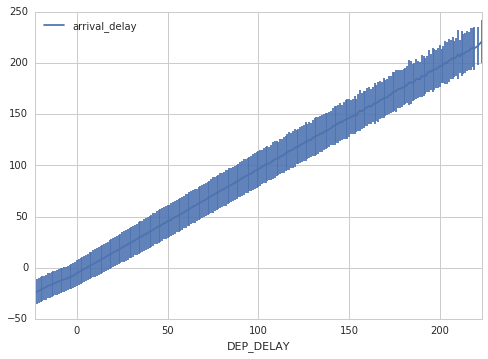

In [31]:
ax = depdelay.plot(kind='line', x='DEP_DELAY', 
              y='arrival_delay', yerr='stddev_arrival_delay')

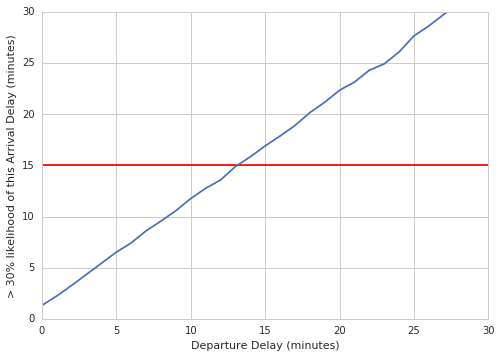

In [32]:
import matplotlib.pyplot as plt
Z_30 = 0.52
depdelay['arr_delay_30'] = (Z_30 * depdelay['stddev_arrival_delay']) \
             + depdelay['arrival_delay']
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arr_delay_30',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)')

In [36]:
depdelayquery2 = """
SELECT
  DEP_DELAY,
  arrival_delay,
  numflights
FROM (
  SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY,
      101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr`
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY
"""

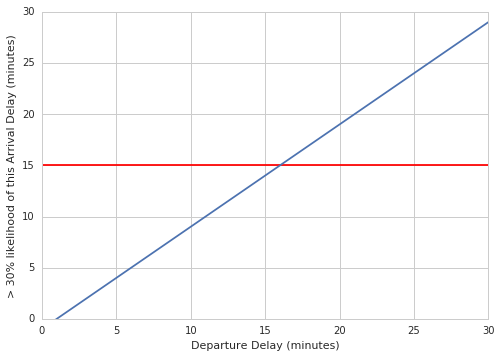

In [37]:
depdelay = bq.Query(depdelayquery2).execute().result().to_dataframe()
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)')

In [39]:
depdelayquery3 = """
SELECT
  DEP_DELAY,
  arrival_delay,
  numflights
FROM (
  SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY,
      101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'True'
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY
"""

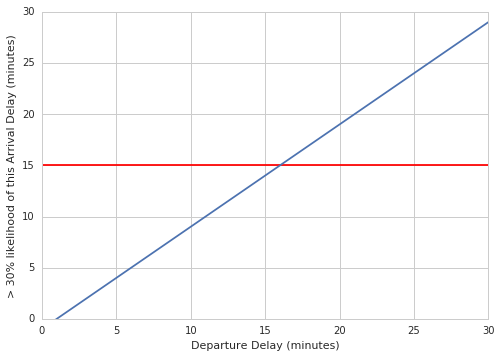

In [41]:
depdelay = bq.Query(depdelayquery3).execute().result().to_dataframe()
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
              ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)')

In [42]:
evalquery = """
SELECT
  SUM(IF(DEP_DELAY < 16
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY < 16
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'False' )
"""

In [43]:
eval = bq.Query(evalquery).execute().result().to_dataframe()
print eval['correct_nocancel'] / (eval['correct_nocancel'] + \
eval['wrong_nocancel'])
print eval['correct_cancel'] / (eval['correct_cancel'] + \
eval['wrong_cancel'])

0    0.950408
dtype: float64
0    0.802263
dtype: float64


In [44]:
eval.head()

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,1389162,72486,58359,236776


In [45]:
evalquery2="""
SELECT
  SUM(IF(DEP_DELAY = 15
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY = 15
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'False' )
"""

In [46]:
eval = bq.Query(evalquery2).execute().result().to_dataframe()
eval.head()

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,8474,3179,7459,3195


In [47]:
print eval['correct_nocancel'] / (eval['correct_nocancel'] + \
eval['wrong_nocancel'])
print eval['correct_cancel'] / (eval['correct_cancel'] + \
eval['wrong_cancel'])

0    0.727195
dtype: float64
0    0.299887
dtype: float64
